In [7]:
!git clone git@github.com:isl-org/ZoeDepth.git

Cloning into 'ZoeDepth'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 111 (delta 38), reused 23 (delta 23), pack-reused 42 (from 2)
Receiving objects: 100% (111/111), 4.09 MiB | 3.88 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [14]:
!wget https://upload.wikimedia.org/wikipedia/commons/e/e7/Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg -O mountains.jpg

--2025-04-29 22:50:09--  https://upload.wikimedia.org/wikipedia/commons/e/e7/Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 185.15.59.240, 2a02:ec80:300:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|185.15.59.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903706 (883K) [image/jpeg]
Saving to: ‘mountains.jpg’

mountains.jpg       100%[===================>] 882,53K  1,83MB/s    in 0,5s    

2025-04-29 22:50:10 (1,83 MB/s) - ‘mountains.jpg’ saved [903706/903706]



In [22]:
import torch
import torch.nn as nn
import numpy as np
import sys
import matplotlib
import matplotlib.cm
import pandas as pd

from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from typing import Callable

In [2]:
sys.path.append("ZoeDepth")

In [3]:
from ZoeDepth.zoedepth.utils.config import change_dataset, get_config
from ZoeDepth.zoedepth.models.builder import build_model

In [4]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [5]:
config = get_config(
    model_name="zoedepth",
    mode="eval",
    config_version="kitti",
)
config = change_dataset(config, new_dataset="kitti")

Overwriting config with config_version kitti


In [6]:
model = build_model(config)
model = model.to(device)
model = model.eval()

img_size [384, 768]


Using cache found in /home/ilia-mileshin/.cache/torch/hub/intel-isl_MiDaS_master
/home/ilia-mileshin/Projects/dmb/.venv/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  768
	height:  384
	resize_target:  True
	keep_aspect_ratio:  False
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_K.pt
Loaded successfully


In [7]:
model

ZoeDepth(
  (core): MidasCore(
    (core): DPTDepthModel(
      (pretrained): Module(
        (model): Beit(
          (patch_embed): PatchEmbed(
            (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
            (norm): Identity()
          )
          (pos_drop): Dropout(p=0.0, inplace=False)
          (blocks): ModuleList(
            (0-23): 24 x Block(
              (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (attn): Attention(
                (qkv): Linear(in_features=1024, out_features=3072, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=1024, out_features=1024, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=1024, out_features=4096, bias=Tru

In [8]:
def colorize(
    value: torch.Tensor | np.ndarray,
    vmin: float | None = None,
    vmax: float | None = None,
    cmap: str = "magma_r",
    invalid_val: float = -99,
    invalid_mask: np.ndarray | None = None,
    background_color: tuple[int, int, int, int] = (128, 128, 128, 255),
    gamma_corrected: bool = False,
    value_transform: Callable[[np.ndarray], np.ndarray] | None = None,
) -> np.ndarray:
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarray): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
    mask = np.logical_not(invalid_mask)

    # normalize
    vmin = np.percentile(value[mask], 2) if vmin is None else vmin
    vmax = np.percentile(value[mask], 85) if vmax is None else vmax
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.0

    # squeeze last dim if it exists
    # grey out the invalid values

    value[invalid_mask] = np.nan
    cmapper = matplotlib.colormaps[cmap]
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (n x m x4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)

    return img

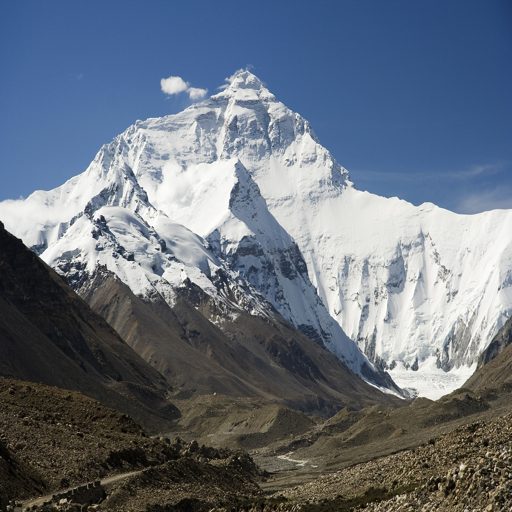

In [9]:
image = Image.open("mountains.jpg")
display(image.resize((512, 512)))

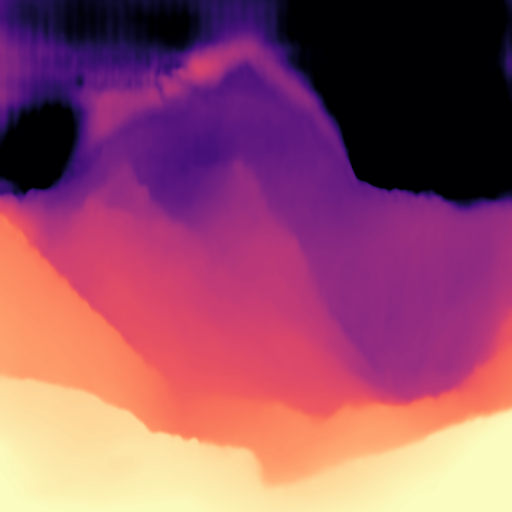

In [10]:
pred_depth = model.infer_pil(image, output_type="tensor")
depth_colorized = Image.fromarray(colorize(pred_depth))
display(depth_colorized.resize((512, 512)))

In [11]:
KITTI_DEPTH_SELECTION_PATH = Path("datasets/depth_selection")

In [12]:
class KittiDepthDatasetSelection(Dataset):
    def __init__(self):
        super().__init__()
        self.image_path = KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "image"
        self.ground_truth_path = (
            KITTI_DEPTH_SELECTION_PATH / "val_selection_cropped" / "groundtruth_depth"
        )
        self.image_paths, self.ground_truth_paths = self._prepare_data()

    def _get_image_params(self, image_path: Path) -> tuple[str, str, str, str]:
        params = image_path.stem.split("_")
        date = f"{params[0]}_{params[1]}_{params[2]}"
        record_index = params[4]
        index = params[-3]
        cam = params[-1]
        return date, record_index, index, cam

    def _prepare_data(self) -> tuple[list[Path], list[Path]]:
        image_paths = []
        ground_truth_paths = []
        for image_path in self.image_path.iterdir():
            date, record_index, index, cam = self._get_image_params(image_path)
            ground_truth_path = (
                self.ground_truth_path
                / f"{date}_drive_{record_index}_sync_groundtruth_depth_{index}_image_{cam}.png"
            )
            if not ground_truth_path.exists():
                print(f"Ground truth path {ground_truth_path} does not exist")
            image_paths.append(image_path)
            ground_truth_paths.append(ground_truth_path)
        return image_paths, ground_truth_paths

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> tuple[Image.Image, np.ndarray, np.ndarray]:
        image = Image.open(self.image_paths[idx])
        ground_truth = Image.open(self.ground_truth_paths[idx])
        ground_truth = np.ascontiguousarray(ground_truth).astype(float) / 256.0
        valid_mask = (ground_truth > 0).astype(int)
        return image, ground_truth, valid_mask

In [13]:
def eval_depth(pred: torch.Tensor, target: torch.Tensor) -> dict[str, float]:
    assert pred.shape == target.shape

    thresh = torch.max((target / pred), (pred / target))

    d1 = torch.sum(thresh < 1.25).float() / len(thresh)
    d2 = torch.sum(thresh < 1.25**2).float() / len(thresh)
    d3 = torch.sum(thresh < 1.25**3).float() / len(thresh)

    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    abs_rel = torch.mean(torch.abs(diff) / target)
    sq_rel = torch.mean(torch.pow(diff, 2) / target)

    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log, 2)))

    log10 = torch.mean(torch.abs(torch.log10(pred) - torch.log10(target)))
    silog = torch.sqrt(
        torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2)
    )

    return {
        "d1": d1.item(),
        "d2": d2.item(),
        "d3": d3.item(),
        "abs_rel": abs_rel.item(),
        "sq_rel": sq_rel.item(),
        "rmse": rmse.item(),
        "rmse_log": rmse_log.item(),
        "log10": log10.item(),
        "silog": silog.item(),
    }

In [14]:
selection_dataset = KittiDepthDatasetSelection()

In [15]:
idx = 67
img, true_depth, valid_mask = selection_dataset[idx]

true_depth = torch.from_numpy(true_depth).type(torch.float32)
valid_mask = torch.from_numpy(valid_mask)

pred_depth = model.infer_pil(img, output_type="tensor")
pred_depth = pred_depth.squeeze()

mask = (valid_mask == 1) & (true_depth >= 0.001) & (true_depth <= 80)

eval_depth(pred_depth[mask], true_depth[mask])

{'d1': 0.9917820692062378,
 'd2': 0.9980789422988892,
 'd3': 0.9998340010643005,
 'abs_rel': 0.10979919135570526,
 'sq_rel': 0.24301578104496002,
 'rmse': 2.270428419113159,
 'rmse_log': 0.12488054484128952,
 'log10': 0.04456484690308571,
 'silog': 0.10932352393865585}

In [ ]:
img

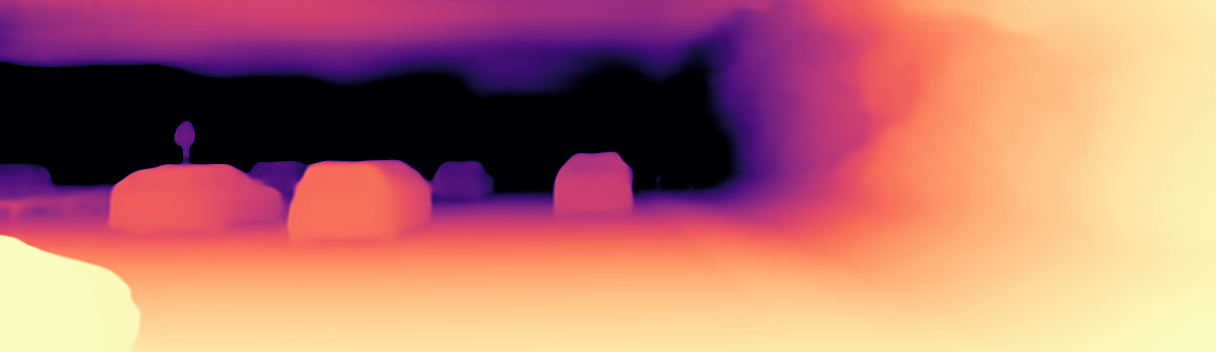

In [16]:
depth_colorized = Image.fromarray(colorize(pred_depth))
depth_colorized

In [21]:
metrics = []

for img, true_depth, valid_mask in tqdm(
    selection_dataset, total=len(selection_dataset)
):
    true_depth = torch.from_numpy(true_depth).type(torch.float32)
    valid_mask = torch.from_numpy(valid_mask)

    pred_depth = model.infer_pil(img, output_type="tensor")
    pred_depth = pred_depth.squeeze()

    mask = (valid_mask == 1) & (true_depth >= 0.001) & (true_depth <= 80)

    metrics.append(eval_depth(pred_depth[mask], true_depth[mask]))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
metrics = pd.DataFrame(metrics)
metrics.head()

,d1,d2,d3,abs_rel,sq_rel,rmse,rmse_log,log10,silog
0,0.967788,0.998830,0.999740,0.159380,0.410459,3.001982,0.156069,0.063754,0.118479
1,0.881483,0.997039,0.999256,0.199756,0.716604,3.935230,0.189383,0.078707,0.142531
2,0.699157,0.996179,0.997981,0.206495,0.835891,4.332931,0.200849,0.080541,0.158310
3,0.994658,0.998814,0.999401,0.104515,0.231892,2.189291,0.122407,0.042489,0.109654
4,0.969152,0.996603,0.997901,0.168124,0.417501,3.015167,0.168989,0.067632,0.132379


In [25]:
metrics.mean()

d1          0.921383
d2          0.995610
d3          0.999090
abs_rel     0.171161
sq_rel      0.525540
rmse        3.251882
rmse_log    0.168361
log10       0.067986
silog       0.130504
dtype: float64